<a href="https://colab.research.google.com/github/Samuel-Evan-s/Machine_Learning/blob/main/Digit_Recognizer_MNIST_using_LeNet_on_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing necessary Libraries**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data import random_split

**Data Loading**

In [ ]:
# --- 1. SETUP DEVICE ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 2. DATA PREPARATION ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Downloading MNIST (Handwritten Digits)
full_train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_set, val_set = random_split(full_train_set, [50000, 10000])

batch_size = 32
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

Using device: cpu


**Data Exploration**

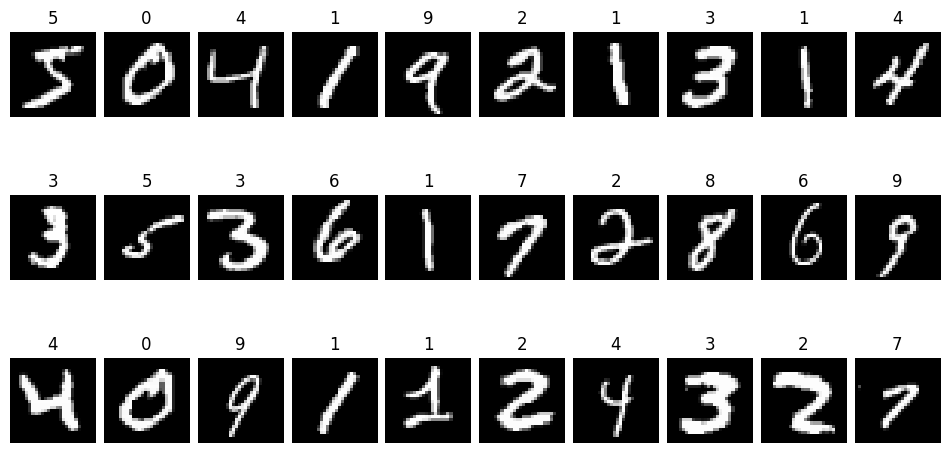

In [ ]:
from matplotlib import image
rows = 10
cols = 2

num_cols = 10
num_rows = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    image, label = full_train_set[i]
    image = image.squeeze(0)
    ax.imshow(image, cmap='gray')
    ax.set_title(label)
    ax.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

**Model Building**

In [ ]:
# --- 3. MODEL BUILDING (LeNet5) ---
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2), # Padding added to handle 28x28 input better
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

In [ ]:
model = LeNet5(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# --- 4. TRAINING LOOP ---
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation Phase
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Epoch {epoch+1} | Loss: {running_loss/len(trainloader):.4f} | Val Acc: {100*correct/total:.2f}%')

Epoch 1 | Loss: 0.2495 | Val Acc: 96.27%
Epoch 2 | Loss: 0.0888 | Val Acc: 97.22%
Epoch 3 | Loss: 0.0598 | Val Acc: 97.89%
Epoch 4 | Loss: 0.0481 | Val Acc: 98.15%
Epoch 5 | Loss: 0.0394 | Val Acc: 98.02%


In [ ]:
# --- 5. EVALUATION ON TEST SET ---
model.eval()
test_correct = 0
test_total = 0
all_predictions = []
model.eval()
test_correct = 0
test_total = 0
all_predictions = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_predictions.extend(predicted.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
print(f"\nFinal Test Set Accuracy: {test_accuracy:.2f}%")



Final Test Set Accuracy: 98.13%


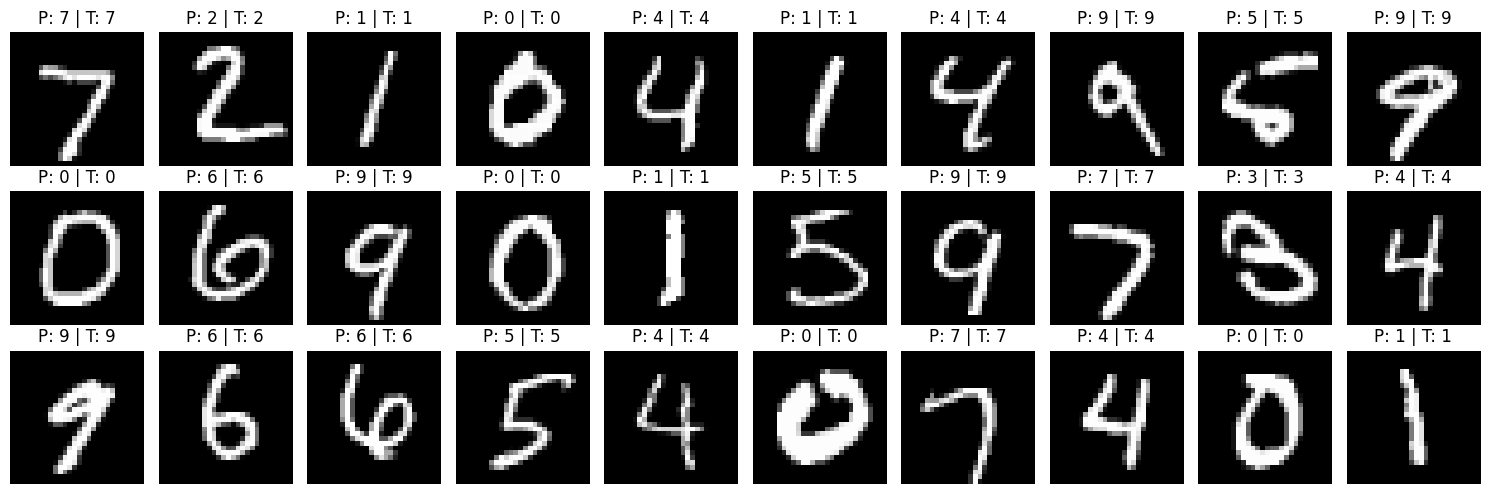

In [ ]:
# ---- 6. VISUALIZING THE PREDICTIONS ----
images, labels = next(iter(testloader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

fig, axes = plt.subplots(3, 10, figsize=(15, 5))

for i, ax in enumerate(axes.flat):
    img = images[i].cpu().squeeze(0)
    ax.imshow(img, cmap="gray")
    ax.set_title(f"P: {preds[i].item()} | T: {labels[i].item()}")
    ax.axis("off")

plt.tight_layout()
plt.show()